In [31]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns


In [9]:
def load_config():
    # Get the absolute path of the project root (one directory up)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Normalize the project_root to ensure it's correctly formatted
    project_root = os.path.normpath(project_root)
    
    config_path = os.path.join(project_root, 'config.json')

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at expected location: {config_path}")

    with open(config_path, 'r') as f:
        config = json.load(f)

    return config, project_root


In [10]:
config, project_root = load_config()

csv_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["enterprise"]))
csv_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["mobile"]))
csv_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["ics"]))
technique_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["enterprise"]))
technique_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["mobile"]))
technique_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["ics"]))

#csv_path_enterprise, csv_path_mobile, csv_path_ics


In [11]:
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='groups')

# Extract the unique IDs from the first sheet (universe of techniques)
observed_group_ids_enterprise = df_group_enterprise['ID'].unique()
print(len(observed_group_ids_enterprise))


148


In [12]:
df_group_mobile = pd.read_excel(csv_path_mobile, sheet_name='groups')

observed_group_ids_mobile = df_group_mobile['ID'].unique()
print(len(observed_group_ids_mobile))

13


In [13]:
df_group_ics = pd.read_excel(csv_path_ics, sheet_name='groups')

observed_group_ids_ics = df_group_ics['ID'].unique()
print(len(observed_group_ids_ics))

14


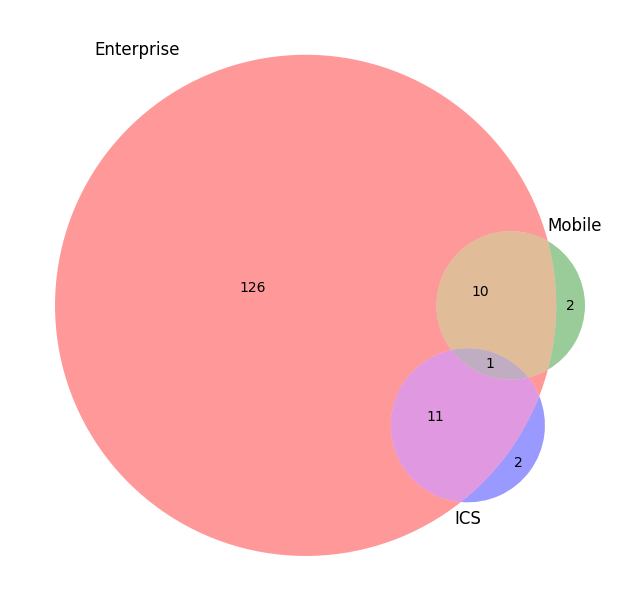

In [14]:
##Ploting group intersection figure across the domains
# Convert lists to sets for easier manipulation
enterprise_set = set(observed_group_ids_enterprise)
mobile_set = set(observed_group_ids_mobile)
ics_set = set(observed_group_ids_ics)
# Create a Venn diagram with 3 sets
plt.figure(figsize=(8, 8))
venn = venn3([enterprise_set, mobile_set, ics_set], ('Enterprise', 'Mobile', 'ICS'))

# Display the plot
#plt.title("Venn Diagram of Group IDs across Enterprise, Mobile, and ICS")
#plt.savefig("figure/venn_diagram_groups.pdf", format='pdf')
#plt.show()


In [17]:
# Find techniques that are in all three sets (intersection)
groups_in_all_three = enterprise_set & mobile_set & ics_set

# Find techniques that are only in mobile (difference with enterprise and ICS)
groups_only_in_mobile = mobile_set - (enterprise_set | ics_set)

# Find techniques that are only in ICS (difference with enterprise and mobile)
groups_only_in_ics = ics_set - (enterprise_set | mobile_set)

# Output the results
print("Groups in all three categories (Enterprise, Mobile, ICS):")
print(groups_in_all_three)

print("Groups only in Mobile (not in Enterprise or ICS):")
print(groups_only_in_mobile)

print("Groups only in ICS (not in Enterprise or Mobile):")
print(groups_only_in_ics)


Groups in all three categories (Enterprise, Mobile, ICS):
{'G0034'}
Groups only in Mobile (not in Enterprise or ICS):
{'G0097', 'G1029'}
Groups only in ICS (not in Enterprise or Mobile):
{'G1027', 'G1000'}


In [24]:
# Helper function to load 'techniques in all the domains' data
def load_techniques(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques')
    return df[['ID', 'name']]

dfs = [load_techniques(f) for f in [technique_path_enterprise, technique_path_mobile, technique_path_ics]]
all_techniques = pd.concat(dfs, ignore_index =True)

#all_techniques

In [27]:
# Helper function to load 'techniques used by group in all the domains' data
def load_techniques_used_group(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques used')
    return df[['source ID', 'target ID']]

# Combine group technique mappings from all sources
dfs = [load_techniques_used_group(f) for f in [csv_path_enterprise, csv_path_mobile, csv_path_ics]]
combined_df = pd.concat(dfs, ignore_index=True)

In [28]:
# Calculate observed and unobserved techniques
observed_ids = combined_df['target ID'].unique()
unobserved_techniques = all_techniques[~all_techniques['ID'].isin(observed_ids)]

# Stats
total_techniques = len(all_techniques)
observed_techniques = len(observed_ids)
unobserved_count = len(unobserved_techniques)
unique_groups = combined_df['source ID'].nunique()

# Output statistics
print(f"Total techniques reported by MITRE: {total_techniques}")
print(f"Total techniques observed across all domains among groups: {observed_techniques}")
print(f"Techniques not observed in any domain: {unobserved_count}")
print(f"Total unique groups: {unique_groups}")

# Display sample group-to-techniques mapping
print("\nSample group techniques mapping:")
sample_groups = combined_df['source ID'].dropna().unique()[:3]
for group_id in sample_groups:
    techniques = combined_df[combined_df['source ID'] == group_id]['target ID'].unique()
    print(f"\nGroup ID: {group_id}")
    print(f"Techniques used ({len(techniques)}): {list(techniques)}")

Total techniques reported by MITRE: 839
Total techniques observed across all domains among groups: 451
Techniques not observed in any domain: 388
Total unique groups: 148

Sample group techniques mapping:

Group ID: G0099
Techniques used (9): ['T1105', 'T1204.002', 'T1036.004', 'T1571', 'T1027', 'T1053.005', 'T1566.001', 'T1588.002', 'T1059.005']

Group ID: G0006
Techniques used (23): ['T1560.001', 'T1119', 'T1005', 'T1583.001', 'T1584.001', 'T1585.002', 'T1003.001', 'T1087.001', 'T1114.001', 'T1588.001', 'T1036.005', 'T1135', 'T1550.002', 'T1057', 'T1021.001', 'T1114.002', 'T1566.001', 'T1566.002', 'T1016', 'T1049', 'T1007', 'T1588.002', 'T1059.003']

Group ID: G0005
Techniques used (5): ['T1102.002', 'T1568.003', 'T1203', 'T1204.002', 'T1566.001']


In [30]:
# Optional: show sample of unobserved techniques
pd.set_option('display.max_rows', 35)
print("\nSample of unobserved techniques (ID and name):")
print(unobserved_techniques.tail(10))


Sample of unobserved techniques (ID and name):
        ID                              name
825  T0881                      Service Stop
827  T0856           Spoof Reporting Message
830  T0894     System Binary Proxy Execution
831  T0857                   System Firmware
832  T0882  Theft of Operational Information
833  T0864             Transient Cyber Asset
834  T0855      Unauthorized Command Message
835  T0863                    User Execution
837  T0860               Wireless Compromise
838  T0887                 Wireless Sniffing


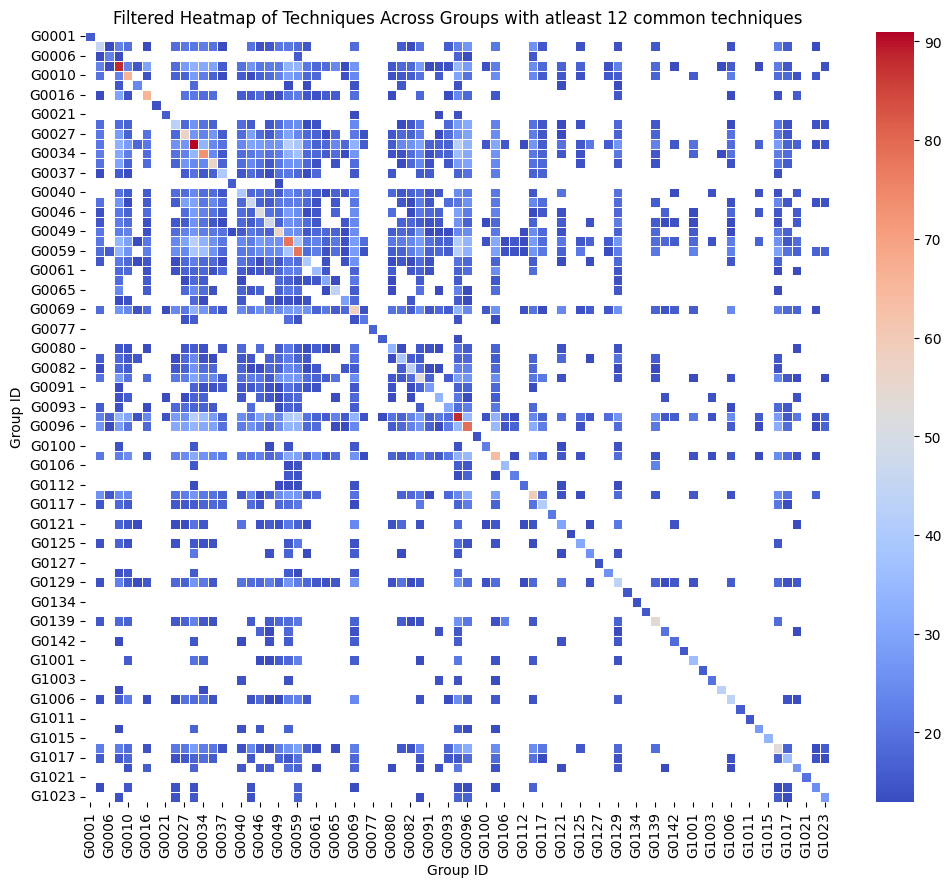

In [35]:
# Load the data
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='techniques used')

# Step 2: Group techniques by "Source ID"
grouped_techniques = df_group_enterprise.groupby('source ID')['target ID'].apply(set)

# Step 3: Initialize an empty co-occurrence matrix
group_ids = grouped_techniques.index
cooccurrence_matrix = pd.DataFrame(0, index=group_ids, columns=group_ids)

# Step 4: Fill the co-occurrence matrix with counts of similar techniques
for group_a in group_ids:
    for group_b in group_ids:
        # Find intersection of techniques between group A and group B
        common_techniques = grouped_techniques[group_a] & grouped_techniques[group_b]
        cooccurrence_matrix.loc[group_a, group_b] = len(common_techniques)

# Set a threshold for minimum shared techniques between groups
min_shared_techniques = 12  # You can adjust this threshold

# Filter the co-occurrence matrix to only show groups with a minimum count of shared techniques
filtered_cooccurrence_matrix = cooccurrence_matrix[cooccurrence_matrix > min_shared_techniques].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Plot the filtered heatmap
plt.figure(figsize=(12, 10))

# Use .0f to handle any floats and display whole numbers
sns.heatmap(filtered_cooccurrence_matrix, annot=False, fmt='.0f', cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Heatmap of Techniques Across Groups with atleast 12 common techniques')
plt.xlabel('Group ID')
plt.ylabel('Group ID')

# Save the plot
plt.savefig("figure/enterprise_technique_cooccurrence_heatmap_12.pdf", format='pdf')
plt.show()

